# Introduction

Our topic for this group project is Regime Trading Using Wasserstein Metric
<br/><br/>
We have the following three key questions:

1. Is the Wasserstein K-Means good at classifying Bullish and Bearish regimes?1
2. Can we generate a profitable trading signal?
3. Is it possible to speed up K-Means while retaining its
core design?

<br/><br/>
There are two main motivaions that interest us:

1. This algorithm has not been developed in the major machine learning packages
2. Examples of Deep learning algorithms using Wasserstein Metric, e.g. Image Retrieval, GAN
 
<br/><br/>
By definition, Wasserstein metric can be thought as the minimal effort to move from one distribution to another. 

It is typically used in optimal transport problems. 

But for our specific task, the Wasserstein distance between two vectors is nothing but the mean absolute power difference of sorted values: 

$W_p(u,v)^p = \frac{1}{N} \sum_{i=1}^N |u_{sorted,i} - v_{sorted,i}|^p$


It eliminates the effect of sequential orders, which might make our clustering problem easier.

<br/><br/>
Data Extraction:  

Hourly price data for all stocks in S&P 500 index were extracted from the IEX (Investor’s Exchange) using **parallel computing**.

Data Cleaning: 
- Calculated Adjusted Prices
- Filtered stocks that do not have sufficient data in past 5 years 
- Filtered stocks that have absolute log-returns exceeding 30\%
- Forward filled when there are missing values

Data Preprocessing:

5-day rolling window, offset by 1 day

For more details, please refer to the docstring in ```lift``` in ```Data Preprocessing```


# Proposed Method - the Wasserstein K Means Algorithm

Traditional K-Means is an EM style algorithm* that searches for centers 𝜇, minimizing the sum of squared Euclidian distances from each data point to the centroid of its assigned cluster: 

$\sum_{i=1}^k \sum_{x \in S_i} ||x-\mu_i||^2$

Similarly, Wasserstein K-Means is an EM style algorithm that searches for centers 𝜇, minimizing the sum of $p^{th}$ power Wasserstein distances from each data point to the barycenter of its assigned cluster: 

$\sum_{i=1}^k \sum_{x \in S_i} W_p(x,\mu_i)^p$

<br/><br/>
Pseudo Code of our algorithm 
1. Initialize k Centers
2. Expectation: Assign each sample to its closest center (Wasserstein $p$-Metric)
3. Maximization: Update centers for each cluster with argmin of within-cluster Wasserstein $p$-distance
4. Repeat 2-3 until convergence

However, it is very costly to find the barycenters for generally $p$, as it involves minimizing many $deg(p)$ equations. Note that for $p = 1$ (usual default), the Maximisation step updates barycenters using median of sorted values. For $p = 2$, mean of sorted values.

<br/><br/>
Therefore, it gives us room for optimizing our algorithm.


**1. K-means++ intialisation**

**2. Mini-batch gradient descent** 

**3. ADAM Optimizer**


For 1, it is just about cleverly initialising centers, such that they are far from each other. This could avoid non-convergence possibly when some of the clusters become empty sets.

For 2, it is randomly selecting samples from our input matrix for each iteration. Then, we update the barycenters with the gradient from the selected samples. This combines the advantage of full-batch and stochastic gradient descent, making our algorithm more stable and efficient.

For 3, compared with a constant learning rate, it makes use of the expoentially weighted average gradient (momentum) and squared gradients (RMSProp) to speed up learning. It is widely employed in many deep learning algorithms.

<br/><br/>
We also speeded up computation / runtime in the ```Model testing``` section using **parallel computing** and **bayesian optimization**, a strategy for estimating global minima when the objection function does not have a close-formed expression and thus computationally intensive to evaluate. This is more commonly seen in deep learning though.

# Data Analysis

We will mainly have three parts

1. Simulation study on a Merton Jump Diffusion Price Paths consisting of two regimes. There are 10 regime changes in total. Please refer to the ```Simulation Study``` section.

2. Trading Model on the real-life Dataset as describe in ```Introduction``` section. Please refer to the ```Trading Model``` and ```Model Testing``` section.

3. Comparison between our base algorithm (using scipy.optimize.minimize) and our improved algorithm as outlined, in terms of runtime, accuracy and convergence.

### Import

In [ ]:
#!pip install tiingo
#!pip install scikit-optimize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis
import tiingo 
from tiingo import TiingoClient 
import datetime
from datetime import date
from dateutil.relativedelta import relativedelta
from scipy.optimize import minimize
from sklearn.metrics.cluster import adjusted_rand_score
import time
from skopt import gp_minimize
import trade
import multiprocessing as mp
from skopt import space
import pickle

### Extracting Data From IEX

In [ ]:
client = TiingoClient({'api_key':'296d8e8627cf5eb878e6f84435c023614096a5e2'}) #Input API Token for Tiingo API
start = '2017-05-25'
end = '2022-05-25'

def extract_hourly_timeseries_price_data(ticker,start_date = start, end_date = end):
    ticker_history = client.get_dataframe(ticker, frequency='1Hour', metric_name='close', 
                                          startDate= start, endDate= end)
    return ticker_history

In [ ]:
#Create array containing tickers from all companies included in the S&P 500 index
SP_500_Tickers = ['AAPL', 'MSFT','GOOG', 'GOOGL','AMZN','TSLA','BRK.B','FB','NVDA','JNJ','UNH','V','XOM','JPM','PG','WMT',
 'CVX','MA','HD','PFE','LLY','BAC','ABBV','KO','MRK','PEP','AVGO','TMO','VZ','ABT','ADBE','CMCSA','DIS','COST',
 'ACN','ORCL','DHR','CSCO','MCD','INTC','NKE','BMY','LIN','CRM','WFC','TMUS','PM','TXN','AMD','QCOM','UPS','T','UAL',
 'NEE','MS','MDT','COP','UNP','RTX','AMGN','HON','CVS','LOW','SCHW','ANTM','SPGI','IBM','AXP','LMT','AMT','CAT','GS',
 'INTU','C','DE','AMAT','PYPL','MO','BLK','PLD','SYK','ADP','NOW','CB','BKNG','EL','MDLZ','DUK','ADI','SBUX','GE','CI',
 'NFLX','MMM','CHTR','GILD','CCI','ISRG','SO','MU','ZTS','MMC','USB','TGT','BDX','EOG','REGN','BA','CME','NOC','TJX',
 'CSX','SHW','D','VRTX','LRCX','PGR','PNC','PXD','WM','CL','ITW','FISV','FIS','TFC','ATVI','HCA','EQIX','GD','OXY','EW',
 'NSC','SLB','BSX','AON','HUM','PSA','ICE','MRNA','ETN','MCO','NEM','APD','FCX','MPC','FDX','GM','AEP','MAR','MET','SRE',
 'VLO','KLAC','CNC','EMR','DOW','F','NXPI','ADM','KHC','SNPS','MCK','MNST','EXC','DVN','PSX','FTNT','ECL','COF','STZ','LHX',
 'ROP','AIG','KMB','KMI','WMB','HSY','WBD','DG','CTVA','PAYX','ADSK','O','RSG','APH','CDNS','XEL','TRV','GIS','WELL',
 'TEL','SYY','ILMN','IQV','ORLY','A','DLR','CTAS','MCHP','PRU','CTSH','BAX','EA','HPQ','HLT','CMG','SPG','BKR','JCI',
 'AFL','WBA','BK','LYB','HES','SBAC','MSI','AZO','KR','GPN','ED','MSCI','ALL','PEG','PH','HAL','IFF','WEC','AJG','DD','CARR',
 'NUE','YUM','ANET','DXCM','ABC','IDXX','ES','TSN','OTIS','TT','TDG','FAST','BF.B','BIIB','TWTR','MTB','DFS','RMD','DLTR',
 'OKE','PPG','MTD','AMP','AVB','WY','GLW','CMI','EQR','PCAR','ALB','TROW','CERN','ODFL','AME','VRSK','CPRT','AWK','HRL',
 'ARE','CBRE','SIVB','LVS','APTV','LUV','ROST','KEYS','EIX','FRC','DTE','EBAY','DAL','STT','CTRA','ZBH','FITB','DHI','FE',
 'MKC','AEE','EFX','ETR','GWW','ROK','FANG','LH','EXR','K','ENPH','STE','VTR','WST','WTW','BALL','HIG','ANSS',
 'MTCH','ALGN','CDW','LEN','NTRS','CHD','PPL','PARA','VMC','MOS','FTV','MLM','LYV','MAA','IT','TSCO','CF','CMS','DRE',
 'CINF','MPWR','GRMN','AMCR','HOLX','URI','MRO','CNP','WAT','RJF','EXPE','DOV','RF','HBAN','CFG','PKI','CEG','ESS','HPE',
 'VFC','EPAM','IR','GPC','COO','MOH','VRSN','TDY','FOX','FOXA','CTLT','ULTA','FLT','WDC','EXPD','WRB','IP','SWK','PFG','J',
 'ROL','JBHT','STX','ZBRA','KEY','CLX','PAYC','INCY','SWKS','DGX','BXP','TER','CE','TRMB','BR','BBY','SYF','POOL','PWR',
 'WAB','PEAK','AKAM','BIO','BRO','ATO','EVRG','L','OMC','CAG','CAH','FMC','KMX','UDR','NTAP','CPT','LNT','XYL','MGM','DRI',
 'CCL','IRM','TECH','VTRS','SEDG','TYL','NLOK','RCL','IEX','GNRC','APA','NVR','PKG','NDAQ','CPB','HWM','FDS','LDOS','AES',
 'LKQ','KIM','SJM','TFX','TTWO','AVY','TXT','HST','PTC','EMN','JKHY','CHRW','BEN','MAS','CTXS','DPZ','NI','IPG','NDSN',
 'CRL','HAS','QRVO','SBNY','HSIC','LUMN','CBOE','WRK','SNA','TAP','AAP','DISH','REG','NRG','CZR','ABMD','RE','AAL','MKTX','NWS',
 'NWSA','UHS','PHM','ETSY','RHI','WHR','ALLE','CMA','OGN','AIZ','FFIV','JNPR','AOS','BBWI','GL','NLSN','BWA','LW','LNC','DVA',
 'SEE','FBHS','FRT','CDAY','MHK','PNW','IVZ','XRAY','PNR','NWL','HII','TPR','ZION','WYNN','DXC','RL','VNO','ALK','PENN','IPGP',
 'PVH','UA','UAA','NCLH']

In [ ]:
#Split the array of S&P 500 stock tickers into 24 separate sub-arrays.

#Current machine has the capacity to run processes on 6 cores & optimum number of tickers 
#for a single API call is between 15-20. Therefore, four separate iterations of running
#API calls on all 6 cores is optimum, which necessitates 6 x 4 or 24 sub-arrays of tickers.

split_arrays_of_tickers = np.array_split(SP_500_Tickers, 24) 
#Split array of S&P 500 tickers into 24 sub-arrays


start_time = time.time() #Start clock (output of this portion of the script is execution time on the console, 
#which is used to determine when the extraction of the data from the API has been completed)

all_stock_data = [] #Create an array to store the outputs of each pooled process 


for i in range(1,5):
    pool_main = mp.Pool(processes = 6)
    extracted_data = []
    arguments = []
    
    for a in range (6*(i-1), 6*i):
        sub_argument = (start, end, split_arrays_of_tickers[a])
        arguments.append(sub_argument)
        
    extracted_data = pool_main.starmap(extract_hourly_timeseries_price_data, arguments)
    
    all_stock_data.append(extracted_data)


total_execution_time = (time.time() - start_time)

total_execution_time

In [ ]:
pd.set_option('display.max_rows', 100)
        
main_list = []

for a in range(len(all_stock_data)):
    for b in range(len(all_stock_data[a])):
        if(len(all_stock_data[a][b]) == 9128):
            main_list.append(all_stock_data[a][b])
        else:
            for c in range(len(all_stock_data[a][b])):
                main_list.append(all_stock_data[a][b][c])


main_dataframe = pd.DataFrame(main_list[0])

for d in range(1, len(main_list)):
    temp = pd.DataFrame(main_list[d])
    main_dataframe = main_dataframe.join(temp)

In [ ]:
#Stock splits over the last 5 years as of 05/27/2022:

data = ['AAPL', '2020-08-31', 4/1], ['TSLA', '2020-08-31', 5/1], ['NVDA', '2021-07-20', 4/1],['VFC', '2019-05-23', 1062/1000], ['PFE', '2020-11-17', 1054/1000], ['MRK', '2021-06-03', 1048/1000],['T', '2022-04-11', 1324/1000], ['NEE', '2020-10-27', 4/1], ['RTX', '2020-04-03', 15890/10000],['HON', '2018-10-01', 1011/1000], ['HON', '2018-10-29', 1032/1000], ['IBM', '2021-11-04', 1046/1000],['TJX', '2018-11-07', 2/1], ['CSX', '2021-06-29', 3/1], ['BDX', '2022-04-01', 1025/1000], ['SHW', '2021-04-01', 3/1], ['FISV', '2018-03-20', 2/1], ['CNC', '2019-02-07', 2/1], ['EXC', '2022-02-02', 1402/1000],['MET', '2017-08-07', 1122/1000], ['APH', '2021-03-05', 2/1], ['O', '2021-11-15', 1032/1000], ['MCHP', '2021-10-13', 2/1], ['AFL', '2018-03-19', 2/1], ['DD', '2019-06-03', 4725/10000],['FAST', '2019-05-23', 2/1], ['DTE', '2021-07-01', 1175/1000], ['ZBH', '2022-03-01', 103/100], ['ANET', '2021-11-18', 4/1], ['MKC', '2020-12-01', 2/1], ['ODFL', '2020-03-25', 3/2], ['FTV', '2020-10-09', 1195/1000],['HPE', '2017-09-01', 1289/1000], ['MTCH', '2020-07-01', 3502/1000], ['LEN', '2017-11-09', 1017/1000],['IP', '2021-10-01', 1056/1000], ['DOV', '2018-05-09', 1238/1000], ['RJF', '2021-09-22', 3/2],['FMC', '2019-03-04', 1153/1000], ['WRB', '2019-04-03', 3/2], ['WRB', '2022-03-24', 3/2],['BRO', '2018-03-29', 2/1], ['HSIC', '2019-02-08', 1275/1000], ['BF.B', '2018-03-01', 5/4], ['BBWI', '2021-08-03', 1237/1000],['PNR', '2018-05-01', 1489/1000], ['DXC', '2018-06-01', 1156/1000], ['VNO', '2017-07-18', 1237/1000],['ROL', '2018-12-11', 3/2], ['ROL', '2020-12-11', 3/2], ['GE', '2019-02-26', 104/100],['GE', '2021-08-02', 1/8], ['ISRG', '2017-10-06', 3/1], ['ISRG', '2021-10-05', 3/1]

stock_splits = pd.DataFrame(data, columns = ['Ticker', 'Date', 'Adjustment Factor'])

In [ ]:
main_dataframe.index = pd.to_datetime(main_dataframe.index)

pd.options.mode.chained_assignment = None #False positive SettingWithCopyWarning

for a in range(len(stock_splits)):
    date = stock_splits['Date'][a]   
    main_dataframe.loc[:date][stock_splits['Ticker'][a]] = main_dataframe.loc[:date][stock_splits['Ticker'][a]]/(stock_splits['Adjustment Factor'][a])
    main_dataframe.loc[date][stock_splits['Ticker'][a]] = main_dataframe.loc[date][stock_splits['Ticker'][a]]*(stock_splits['Adjustment Factor'][a])

main_dataframe.to_csv('sp500dataff.csv')

### Simulating Synthetic Paths

In [ ]:
def gen_path(S_0,mu,sigma,lam,gamma,delta,dt,size,state):
  rng = np.random.default_rng(state)
  pp = np.multiply(rng.poisson(lam*dt, size=size),rng.normal(gamma,delta, size=size)).cumsum(axis=0)
  bm = np.cumsum((mu-sigma**2/2)*dt +sigma*np.sqrt(dt)*rng.normal(size=size), axis=0)
  return S_0*np.exp(pp+bm)

In [ ]:
def MJD(state,mu_1,sigma_1,lambda_1,gamma_1,delta_1,mu_2,sigma_2,lambda_2,gamma_2,delta_2,T = 20, no_regime = 10, l_regime = 0.5, h = 1/1764):
  """
  Generate a Merton Jump Diffusion Price Paths with two regimes
  """

  rng = np.random.default_rng(state)
  data = pd.DataFrame(index = range(int(T/h)),columns = ['price','log_ret','true_regime'])
  l_t = int(l_regime/h)

  s = rng.choice(int((T-l_regime)/h),size = (1)) 

  while len(s) < 10:
    x = rng.choice(int((T-l_regime)/h)) 

    if (s.min() > x+l_t+2):
      s = np.append(s,x)
      continue

    if (x > s.max() + l_t + 2):
      s = np.append(s,x)
      continue

    if (x > s[s<=x].max() + l_t + 2) and (s[s>=x].min() > x+l_t+2):
      s = np.append(s,x)
  s = np.sort(s)
  print(s)

  data.loc[:s[0]-1,'price'] = gen_path(1,mu_1,sigma_1,lambda_1,gamma_1,delta_1,h,s[0],state)
  data.loc[:s[0]-1,'true_regime'] = 1

  for i in range(10):
    data.loc[s[i]:s[i]+l_t-1,'price'] = gen_path(data.loc[s[i]-1,'price'],mu_2,sigma_2,lambda_2,gamma_2,delta_2,h,l_t,state*10*i)
    data.loc[s[i]:s[i]+l_t-1,'true_regime'] = -1
    if i < 9:
      data.loc[s[i]+l_t:s[i+1]-1,'price'] = gen_path(data.loc[s[i]+l_t-1,'price'],mu_1,sigma_1,lambda_1,gamma_1,delta_1,h,s[i+1]-s[i]-l_t,state*20*(i+1))
      data.loc[s[i]+l_t:s[i+1]-1,'true_regime'] = 1
    else:
      data.loc[s[i]+l_t:,'price'] = gen_path(data.loc[s[i]+l_t-1,'price'],mu_1,sigma_1,lambda_1,gamma_1,delta_1,h,int(T/h)-s[i]-l_t,state*30*(i+2))
      data.loc[s[i]+l_t:,'true_regime'] = 1
  
  data = data.astype('float64')
  data['log_ret'] = np.log(data.price).diff().fillna(np.log(data.price[0]))
  return data

### Base Version Wasserstein KMeans

In [ ]:
def distance(u,v,p):
    """
    u:barycenters
    v:barycenters or data
    """
    return np.mean(abs(v-u)**p,axis = 1)

def obj_func(u,v,p):
    return distance(u,v,p).sum()

In [ ]:
def wkmeans(X,p=1,k=2,tol=1e-8,state=None,max_iter = 500,verbose = False, k_means_pp = True):
    
    """
    Technique Used: EM algorithm; Optimally choosing initial guesses
    X: M x N matrix with M log_ret time_series
    k: Number of clusters
    p: Wp-metric, only a valid metric when p > 1
    Return: (k x N matrix that represents k centroids, array of M labels)
    """
    
    X_sorted = np.sort(X,axis = 1)
    
    rng = np.random.default_rng(state)
    
    if (k_means_pp):
        barycenters_0 = X_sorted[rng.choice(X.shape[0])].reshape(1,-1)
        
        for i in range(k-1):
            min_d = np.array([distance(barycenters_0[i],X_sorted,p) for i in range(barycenters_0.shape[0])]).min(axis = 0)
            barycenters_0 = np.vstack([barycenters_0,X_sorted[min_d.argmax()]])                  

    else:
        barycenters_0 = X_sorted[rng.choice(X.shape[0],k,replace=False)]
        
        
    barycenters_1 = None
    clusters = None
    counter = 0
    

    while (counter <= max_iter):
        
        clusters = np.array([distance(barycenters_0[i],X_sorted,p) for i in range(k)]).argmin(axis = 0)
        
        if (p == 1):
            
            barycenters_1 = np.array([np.median(X_sorted[clusters == i], axis = 0) for i in range(k)])

        elif (p == 2):
            
            barycenters_1 = np.array([np.mean(X_sorted[clusters == i], axis = 0) for i in range(k)]) 
        
        elif (p > 1):

            barycenters_1 = np.array([minimize(obj_func,x0 = barycenters_0[i],
                                               args = (X_sorted[clusters == i],p)).x for i in range(k)])


        counter += 1
        
        loss = np.sum([distance(barycenters_1[i],X_sorted[clusters == i],p).sum() for i in range(k)])
        
        if (verbose):
            
            print("Mean Loss after {} iterations: {}".format(counter,loss/len(X)))
        
        
        if (sum(distance(barycenters_0,barycenters_1,p)) < tol):
        
            #print("Convergence Reached! Number of Iterations: {}".format(counter))
            
            break
        
        else:
            
            barycenters_0 = barycenters_1.copy()
            

    if(counter == max_iter):
        
        print('Maximum Number of Iteration Reached!')
    
    return barycenters_1, clusters

In [ ]:
def predict_regime(X,barycenters,p=1,k=2):
  return(np.array([distance(barycenters[i],np.sort(X,axis=1),p) for i in range (k)]).argmin(axis = 0))

### Mini Batch Wasserstein KMeans

In [ ]:
def mini_batch_wkmeans(X,p=1, k=2, state=None, batch_size=128, max_iter = 500,
                       a = 1e-3, b1 = 0.99,b2 = 0.999, epsilon = 1e-8,k_means_pp = True,cal_loss = False,const_learn = False):
    
    """
    Technique Used: Mini Batch Gradient Descent; ADAM optimizer; Kmeans++
    Significantly reduce runtime for p != 1 and p != 2
    """
  
    X_sorted = np.sort(X, axis = 1)
    rng = np.random.default_rng(state)

    if (k_means_pp):
        barycenters_0 = X_sorted[rng.choice(X.shape[0])].reshape(1,-1)

        for i in range(k-1):
            min_d = np.array([distance(barycenters_0[i],X_sorted, p) for i in range(barycenters_0.shape[0])]).min(axis = 0)
            barycenters_0 = np.vstack([barycenters_0,X_sorted[min_d.argmax()]])                  
    else:
        barycenters_0 = X_sorted[rng.choice(X.shape[0], k, replace=False)]   
    
    barycenters_1 = np.zeros((k, X.shape[1]))

    m = np.zeros((k,X.shape[1]))
    v = np.zeros((k,X.shape[1]))

    batch_loss = np.zeros(max_iter)
    for i in range(max_iter):

        mini_batch = X_sorted[rng.choice(X.shape[0], batch_size, replace=False)] #256 by 10
        mini_clusters = np.array([distance(barycenters_0[c],mini_batch, p) for c in range(k)]).argmin(axis = 0)

        for j in range(k):
            if (sum(mini_clusters==j) == 0):
                barycenters_1[j] = barycenters_0[j]

            else:
                diff = mini_batch[mini_clusters==j] - barycenters_0[j]
                avg_gradient = np.multiply(-p*(abs(diff)**(p-1)), np.sign(diff)).mean(axis = 0)
                
                if (const_learn):
                    barycenters_1[j] = barycenters_0[j] - a* avg_gradient
                    
                else:
                    m[j] = b1*m[j] + (1-b1)*avg_gradient
                    v[j] = b2*v[j] + (1-b2)*avg_gradient**2
                    #m_hat = m[j]/(1-b1**(i+1))
                    #v_hat = v[j]/(1-b2**(i+1))
                    barycenters_1[j] = barycenters_0[j] - a* (m[j]/(1-b1**(i+1))) / ( (v[j]/(1-b2**(i+1))) **0.5+epsilon)
        
        if (cal_loss):
            batch_loss[i] = np.sum([distance(barycenters_1[c],mini_batch[mini_clusters == c],p).sum() for c in range(k)])
        
        
        barycenters_0 = barycenters_1.copy()
    
    if (cal_loss):
        return barycenters_1,np.array([distance(barycenters_1[i],X_sorted,p) for i in range(k)]).argmin(axis = 0),batch_loss
        
    return barycenters_1,np.array([distance(barycenters_1[i],X_sorted,p) for i in range(k)]).argmin(axis = 0)

### Data Preprocessing

In [ ]:
############### Do not change the code
############### Data Transformation

def lift(y,h1,h2):
    """
    y: pd.Series containing univariate log_ret series
    h1: window size
    h2: offset
    Return: m x h1 Matrix containing sliding window of the time series, where m is the max number of slices
    
    Example: transform(df.log_ret.values,35,7) will output a matrix with rows containing a week of hourly returns, offset by one day
    """

    n = len(y)
    m = 1 + (n - h1) // h2 
    ind = np.arange(h1)[None,:] + h2*np.arange(m)[:,None]
    arr = y.values
    return arr[ind]

In [ ]:
def transform_kmeans_labels(labels,h1,h2,k):
    
    """
    Input: the label of sliding windows from a k-means type algorithm
    k: no. of clusters
    Note it works only if h2 divides h1
    Return: the frequency of label for original time series with complete votes
    e.g. if (h1,h2) = (35,7), then each row can have max 5 votes 
    """
    m = len(labels) - h1//h2 + 1
    count = np.array([np.sum(labels[np.arange(h1//h2)[None,:] + np.arange(m)[:,None]] == i,axis = 1) for i in range(k)])
    #[[0,1,2,...],[1,2,3,...],...]
    count = np.tile(count.T,h2).reshape(-1,k) # count is the same for the same h2 rows
    return np.concatenate([np.zeros((h1-h2,k)),count,np.zeros((h1-h2,k))]) # Incomplete votes will be filled with 0

### Data Visualisation

In [ ]:
def dist_plot(data,h1=10,h2=2,p=1,k=2,state = None,color = ['r','g','y','b'],verbose = True):
    """
    data: Lift data
    dist_labels: labels for the distributions
    centers: barycenters
    """
    data_lift = lift(data.log_ret,10,2)
    centers, labels = wkmeans(data_lift,p=p,k=k,k_means_pp = False,state=state,verbose = verbose)

    plt.figure(figsize = (10,8))
    plt.xlabel('SD')
    plt.ylabel('Mean')
    for i in range(k):
      plt.scatter(data_lift.std(axis = 1)[labels == i],data_lift.mean(axis = 1)[labels == i] ,c = color[i], alpha = 0.3, linewidth = 0.5,label = str(i))
    plt.plot(centers.std(axis=1),centers.mean(axis = 1),'ko',marker = 'D',markersize = 8)
    plt.legend()
    plt.show()

    #plt.figure(figsize = (10,8))
    #plt.xlabel('Skewness')
    #plt.ylabel('Kurtosis')
    #for i in range(k):
    #  plt.scatter(skew(data_lift,axis = 1)[labels == i],kurtosis(data_lift,axis = 1)[labels == i] ,c = color[i], alpha = 0.3, linewidth = 0.5,label = str(i))
    #plt.legend()
    #plt.show()

In [ ]:
def plot_stock_regime(data,vote_threshold = 4,state = None,h1=10,h2=2,p=1,k=2,verbose = False,color = ['r','g','y','b','w']):

  lift_data = lift(data.log_ret,h1,h2)

  barycenters,dist_labels = wkmeans(lift_data,p,k,state =state,verbose = verbose,k_means_pp = False)

  price_labels = np.where(transform_kmeans_labels(dist_labels,h1,h2,k) >= vote_threshold)
  data['regime'] = -1
  data.iloc[price_labels[0],-1] = price_labels[1]

  sns.set_theme()
  plt.figure(figsize = (20,12))
  for i in range(-1,k):
    plt.plot(data.index,data.price.mask(data.regime != i,np.nan),c = color[i],label = str(i))
    plt.fill_between(data.index, data.price.min(), data.price.max(), where=data.true_regime == -1 ,facecolor='red', alpha=0.01)
    plt.legend(fontsize = 15)
  plt.show()

  plt.figure(figsize = (20,12))
  for i in range(-1,k):
    plt.plot(data.index,data.log_ret.mask(data.regime != i,np.nan),c = color[i],label = str(i))
    plt.fill_between(data.index, data.log_ret.min(), data.log_ret.max(), where=data.true_regime == -1 ,facecolor='red', alpha=0.01)
    plt.legend(fontsize = 15)
  plt.show()

### Simulation Study

In [ ]:
# Simulating synthetic price paths
# which consist of two data generating process
# So that we can know the actual regime label
data_MJD = MJD(65,0.05, 0.2, 5, 0.02, 0.012, -0.05, 0.4, 10, -0.04, 0.1)

[ 1630  6001  7866 10500 12894 14074 17825 20447 30953 32020]


Mean Loss after 1 iterations: 0.0022296388303316545
Mean Loss after 2 iterations: 0.0022095401194227953
Mean Loss after 3 iterations: 0.0022052701800800018
Mean Loss after 4 iterations: 0.0022016687477146623
Mean Loss after 5 iterations: 0.0021975284993882814
Mean Loss after 6 iterations: 0.0021936649083102834
Mean Loss after 7 iterations: 0.002189725883901212
Mean Loss after 8 iterations: 0.002186828837785836
Mean Loss after 9 iterations: 0.0021851209725978274
Mean Loss after 10 iterations: 0.002184153255151703
Mean Loss after 11 iterations: 0.0021836737943112844
Mean Loss after 12 iterations: 0.0021835376778493085
Mean Loss after 13 iterations: 0.0021835195190642387
Mean Loss after 14 iterations: 0.0021835149893876457
Mean Loss after 15 iterations: 0.0021835128839694153
Mean Loss after 16 iterations: 0.002183512646687569
Mean Loss after 17 iterations: 0.002183512551074559
Mean Loss after 18 iterations: 0.0021835124197870674
Mean Loss after 19 iterations: 0.002183512414254628
Mean Los

/var/folders/rj/_tdb5p8j63b8bg8xxz9c7yl80000gn/T/ipykernel_98322/3092146559.py:15: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "ko" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(centers.std(axis=1),centers.mean(axis = 1),'ko',marker = 'D',markersize = 8)


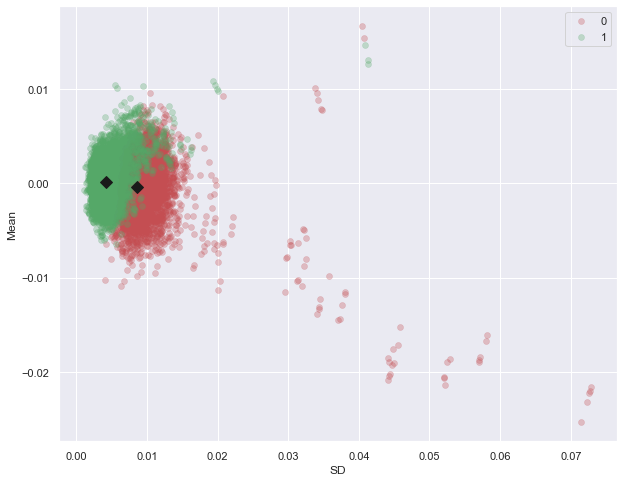

In [ ]:
dist_plot(data_MJD,k=2,state = 3) # This state gives min loss

We can see there is vaguely a decision boundary on standard deviation.

The bearish regime has lower mean, higher volatility as expected from the data generation process

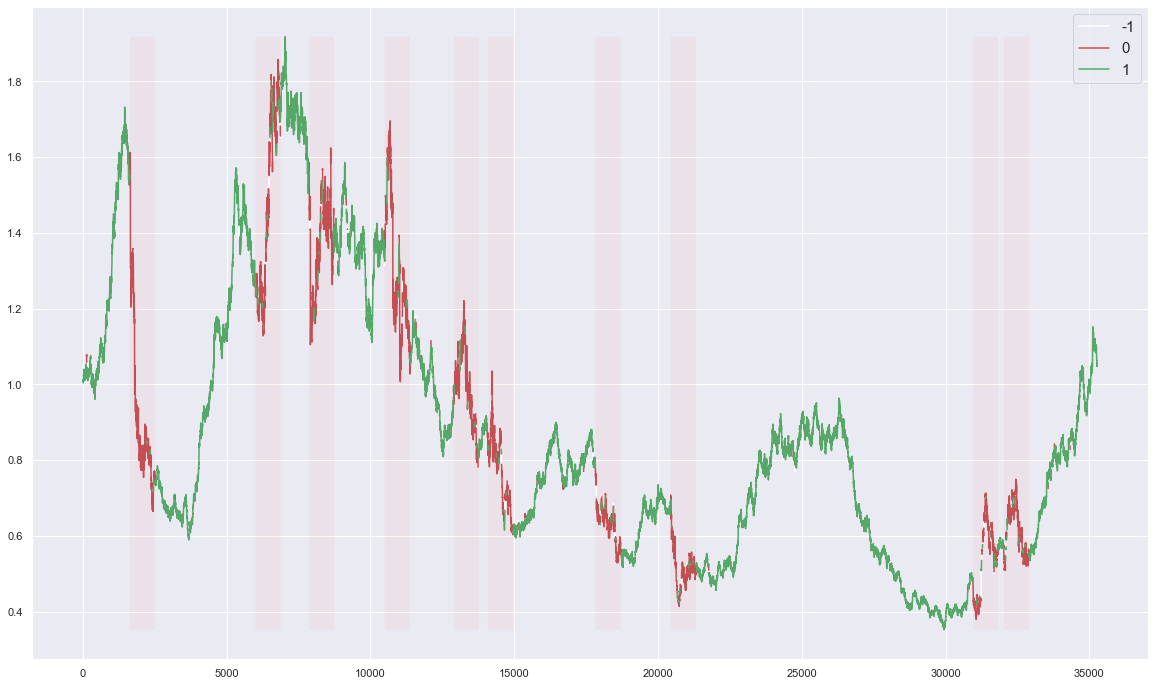

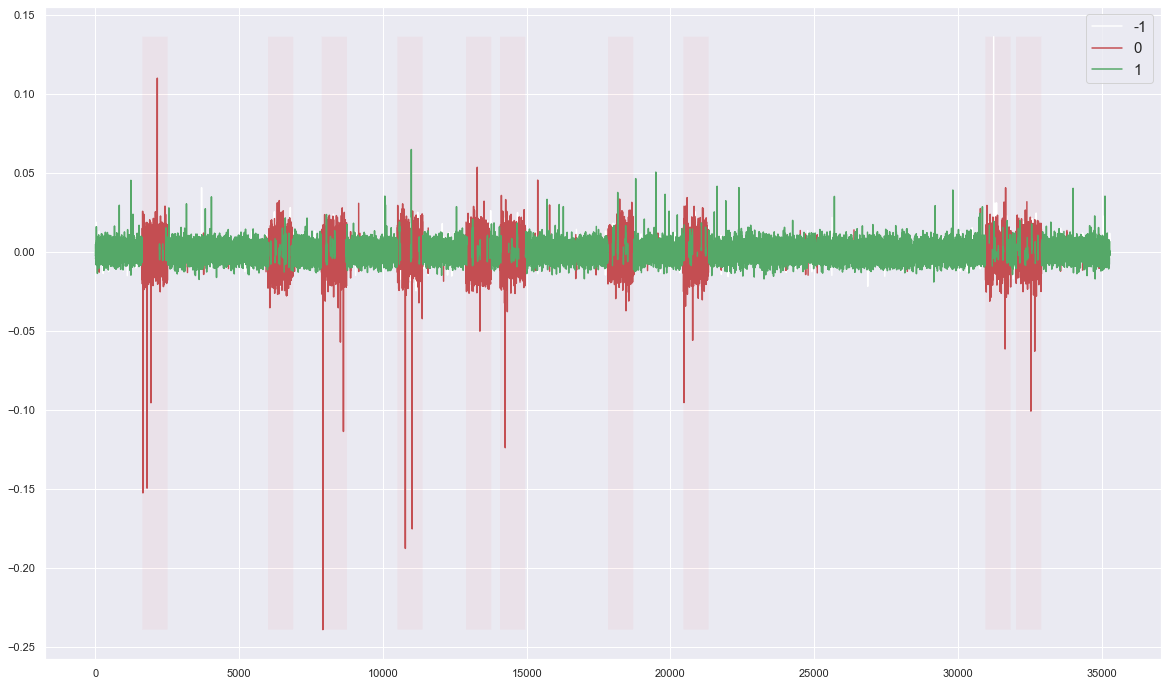

In [ ]:
plot_stock_regime(data_MJD,state = 3)
# -1 means transition
# Red bar is the true regime

The red filled area is the true regime as we generated this synthetic path. 

As a result, we see that our Wasserstein K means almost perfectly classifies regime changes.

Yet, we can still see some misclassification, such as around t = 25000, there are some red colours

### Trading Model

In [ ]:
def trade_sim(data,p=1,k=2,h1=35,h2=7,state = None):
  data.columns = ['close']
  data['log_ret'] = np.log(data['close']).diff(1)
  data = data.fillna(0)
  data['weight'] = 0.0
  lift_data = lift(data.log_ret,h1,h2)
  
  n = lift_data.shape[0]
  print(n)
  train_lift_data = lift_data[:int(n*0.5)] #0:650
  valid_lift_data = lift_data[int(n*0.5):int(n*0.8)] #650:1040
  test_lift_data = lift_data[int(n*0.8):] #1040:1301

  if ((p == 1) or (p == 2)):
    train_barycenters,train_dist_labels = wkmeans(train_lift_data,p,k,state=state)
  else:
    train_barycenters,train_dist_labels = mini_batch_wkmeans(train_lift_data,p,k,state=state)

  act_ret = data['log_ret'].groupby(data.index.date).sum().iloc[h1//h2:int(n*0.5)+(h1//h2)] 
  # Training data's actual data, group by date, prediction starts from the 5th day, if we use h1=35,h2=7
    

  train_dist_labels = np.array(train_dist_labels,dtype = 'f')

  for i in range(k):
    train_dist_labels[train_dist_labels==i] = np.mean(train_barycenters[i].mean())

  correlation = np.corrcoef(np.sign(train_dist_labels),np.sign(act_ret))[0,1]
  trading_weight = [correlation*(abs(correlation) >= 0.05)*np.sign(train_barycenters.mean(axis=1)[i]) for i in range(k)]

  valid_dist_labels = np.array(predict_regime(valid_lift_data,train_barycenters),dtype = 'f') 
  test_dist_labels = np.array(predict_regime(test_lift_data,train_barycenters),dtype = 'f')
  #e.g. valid_dist_labels: first data is 910*7:915*7, that means we are using it to predict 915*7:916*7
  #Next label is to predict 916*7:917*7
  

  #Change the labels into trading weights
  for i in range(k):
    valid_dist_labels[valid_dist_labels == i] = trading_weight[i]
    test_dist_labels[test_dist_labels == i] = trading_weight[i]

  # Giving weights for each row
  for i in range(len(valid_dist_labels)):
    data.iloc[(int(n*0.5)+h1//h2+i)*7:(int(n*0.5)+h1//h2+i+1)*7,-1] = valid_dist_labels[i]
  for i in range(len(test_dist_labels)):  
    data.iloc[(int(n*0.8)+h1//h2+i)*7:(int(n*0.8)+h1//h2+i+1)*7,-1] = test_dist_labels[i]

  data['pnl'] = data.weight.mul(data.log_ret)
  return(data)

1. In training data (2.5 year), for each stock:
- Get barycenters from Wasserstein kmeans
- Get the correlation of predicted log-returns’ sign with sign of the associated
barycenters’ mean
- If abs(correlation) >= 5%, we will trade it
2. In validation data (1.5 year), for each trading stock
- Denote weights[k] := [correlation * sign(barycenters[k].mean)]
- Get predicted label for each day
- Buy weights[k] shares


- Get the return time series using this strategy
- Search for optimal (p* , k* ) using validation Sharpe := mean(return) / sd(return)

3. Run the trading model using (p* , k* ) in testing data (1 year)

### Hyperparameter Tuning and Model testing

In [ ]:
all_stock_data = pd.read_csv('sp500dataff.csv',index_col=0)
all_stock_data.index = pd.to_datetime(all_stock_data.index)

stocks = all_stock_data.columns
stocks_split = np.array_split(stocks, 4)


In [ ]:
def get_sharpe(args):
    """
    Technique Used: Parallel Computing
    Calculate the hourly sharpe ratio := mean(hourly return) / std(hourly return) for the validation dataset
    Note: might need to import trade module in the zip file for result reproduction
    """
    pnl = []
    pool = mp.Pool(4)
    print(args[0])
    x = pool.starmap(trade.trade_sim, [(pd.DataFrame(all_stock_data[i]),args[0],2,35,7,0) for i in stocks])
    pnl.append(x)
    pool.close()
    pool.join()
    all_pnl = pd.concat(pnl[0],axis = 1)
    r = all_pnl['pnl'].sum(axis = 1).iloc[655*7:1045*7] 
    # The log return during the validation period using our trading model
    return(-1 * r.mean()/r.std())


In [ ]:
search_space = space.Space([space.Real(1, 10, "uniform", name='p')])
res_gp = gp_minimize(get_sharpe, search_space, n_calls=100, random_state=None,n_jobs = -1,verbose = True)
# Using state None to avoid any bias in prediction due to state

In [ ]:
#hyper_file = open("hyper.txt", "wb")
#pickle.dump(res_gp, hyper_file)
#hyper_file.close()
hyper_file = open("hyper.txt","rb")
res_gp = pickle.load(hyper_file)
hyper_file.close()
print(res_gp.x_iters,res_gp.func_vals)

[[6.335601564025166], [8.598391737229157], [8.721510558604813], [8.62526564905713], [6.612073271073752], [4.459435365634299], [3.677811458900251], [1.5104167958569887], [3.4539066512210193], [5.29898605589215], [7.154142029083443], [10.0], [7.728342534184808], [7.204906470181262], [7.592381753644958], [7.004936138624824], [10.0], [6.0002234248791755], [7.554179577715698], [1.0014605877167169], [7.942923373296695], [2.7400414881773654], [7.952816789623552], [6.304682014969677], [5.400822857731411], [9.99746700387118], [5.1076149726554645], [6.43116255458048], [4.258788246053712], [7.427428749564718]] [-0.02561174 -0.01734401 -0.02422783 -0.01245581 -0.03267633 -0.01095725
 -0.02104666  0.00379734 -0.00970237 -0.00827812 -0.0220349  -0.02068718
 -0.03311212 -0.0292395  -0.0294586  -0.0049733   0.00472503 -0.01742304
 -0.02659313  0.00184251 -0.02718346 -0.01940835 -0.02339198 -0.02618593
 -0.03417373 -0.01477494 -0.01509533 -0.0166242   0.00161948 -0.01552481]


In [ ]:
final_pnl = pd.concat([trade_sim(pd.DataFrame(all_stock_data[i]),p = res_gp.x[0], k=2,state=0)[['pnl','log_ret']] for i in stocks],axis=1)
#final_pnl.to_csv('final_pnl.csv')

In [ ]:
#final_pnl = pd.read_csv('final_pnl.csv',index_col=0)
#final_pnl.index = pd.to_datetime(final_pnl.index)

In [ ]:
valid_pnl = final_pnl.iloc[:,::2].iloc[655*7:1045*7].sum(axis=1)
valid_pnl = valid_pnl/valid_pnl.std()
test_pnl = final_pnl.iloc[:,::2].iloc[1045*7:].sum(axis=1)
test_pnl = test_pnl/test_pnl.std()

valid_market = final_pnl.iloc[:,1::2].iloc[655*7:1045*7].sum(axis=1)
valid_market = valid_market/valid_market.std()
test_market = final_pnl.iloc[:,1::2].iloc[1045*7:].sum(axis=1)
test_market = test_market/test_market.std()

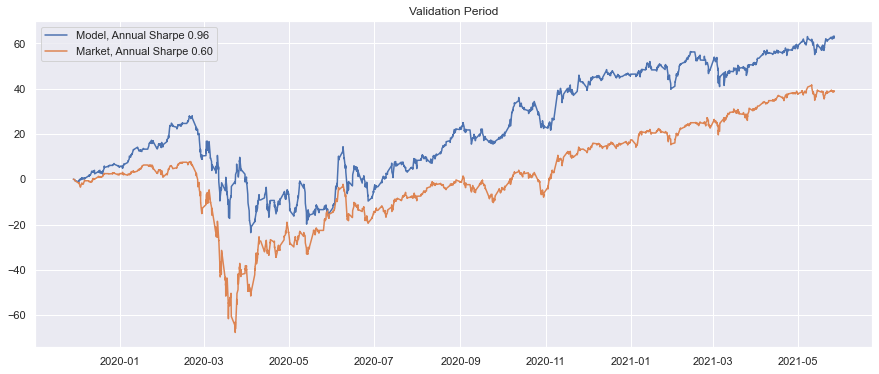

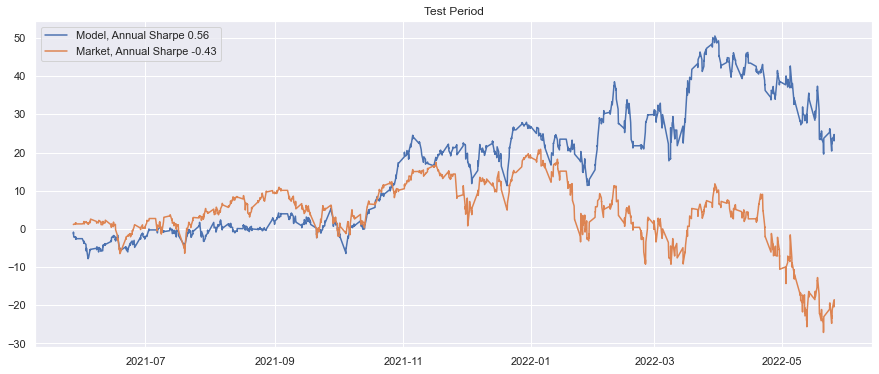

In [ ]:
plt.figure(figsize=(15,6))
valid_sharpe = valid_pnl.mean()/valid_pnl.std()
plt.title('Validation Period')
plt.plot(valid_pnl.cumsum(),label = 'Model, Annual Sharpe {:.2f}'.format(valid_pnl.mean() * 42)) 
plt.plot(valid_market.cumsum(),label = 'Market, Annual Sharpe {:.2f}'.format(valid_market.mean() * 42))
plt.legend()
plt.show()

plt.figure(figsize=(15,6))
plt.title('Test Period')
plt.plot(test_pnl.cumsum(),label = 'Model, Annual Sharpe {:.2f}'.format(test_pnl.mean() * 42))
plt.plot(test_market.cumsum(),label = 'Market, Annual Sharpe {:.2f}'.format(test_market.mean() * 42))
plt.legend()
plt.show()
#Note: sqrt(252 * 7), no of trading days times trading hours

Pros:
- Higher-than-market Sharpe
- Outperformed as market is
more volatile

Cons:
- Optimal Sharpe > 1
- Not market neutral
- Used with other signals

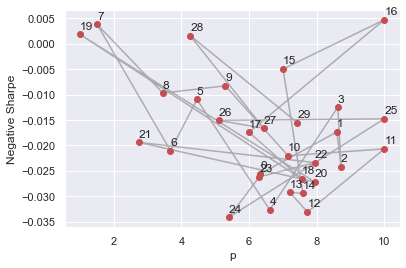

In [ ]:
sns.set_theme()
plt.plot(res_gp.x_iters,res_gp.func_vals,zorder = 1,alpha = 0.3,color = 'k')
plt.scatter(res_gp.x_iters,res_gp.func_vals,color = 'r')
for i in range(len(res_gp.x_iters)):
    plt.annotate(str(i), (res_gp.x_iters[i][0], res_gp.func_vals[i] + 0.001))
plt.xlabel('p')
plt.ylabel('Negative Sharpe')
plt.show()

We can see Bayesian optimisation cleverly samples more points that have a higher probability of being the minima

### Performance of Mini-batch Wasserstein KMeans vs Full-batch Wasserstein KMeans

In [ ]:
data_test = all_stock_data[['AAPL']]
data_test.columns = ['close']
data_test['log_ret'] = np.log(data_test['close']).diff(1)
data_test = data_test.fillna(0)
data_test = lift(data_test.log_ret,35,7)

In [ ]:
data_test.shape

(1301, 35)

In [ ]:
t0 = time.time()
b1,l1 = wkmeans(data_test,p=1.5,k=2,verbose = False,state = 0)
print(time.time()-t0)

102.89276599884033


In [ ]:
times = np.zeros(100)
rand_scores = np.zeros(100)
for i in range(100):
  t0 = time.time()
  b2,l2 = mini_batch_wkmeans(data_test,p=1.5,k=2,
                             batch_size = 128,max_iter = 500,state = None)
  times[i] = time.time() - t0
  rand_scores[i] = adjusted_rand_score(l1,l2)

In [ ]:
pd.DataFrame({'time':times,'score':rand_scores}).describe()

,time,score
count,100.000000,100.000000
mean,0.749581,0.913122
std,0.177833,0.041763
min,0.640312,0.784745
25%,0.650465,0.892174
50%,0.665798,0.923065
75%,0.768111,0.942253
max,1.496578,0.975155


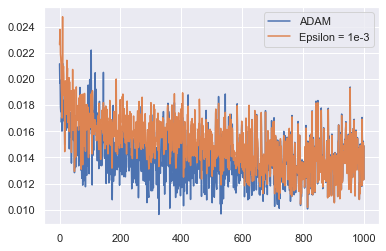

In [ ]:
plt.plot(mini_batch_wkmeans(data_test,p=1.5,k=2,batch_size = 128,max_iter = 1000,
                            state = 0,cal_loss = True)[2],label = 'ADAM')
plt.plot(mini_batch_wkmeans(data_test,p=1.5,k=2,batch_size = 128,max_iter = 1000,
                            state = 0,cal_loss = True, const_learn = True)[2],label = 'Epsilon = 1e-3')

plt.legend()
plt.show()

# Conclusion

To answer our key questions:

1. Wasserstein K means is good at **classifying** regime changes

2. Wasserstein K means is satisfactory at **predicting** regime changes, and generates a profitable trading signal for us. 

3. We have successfully optimized our Wasserstein K means using computational techniques

# References

https://arxiv.org/pdf/2110.11848.pdf

https://proceedings.neurips.cc/paper/1994/file/a1140a3d0df1c81e24ae954d935e8926-Paper.pdf

https://arxiv.org/pdf/1412.6980.pdf

https://www.researchgate.net/publication/222451587_Option_Prices_When_Underlying_Stock_Returns_Are_Discontinuous

https://proceedings.neurips.cc/paper/2011/file/86e8f7ab32cfd12577bc2619bc635690-Paper.pdf


In the original paper, the authors only provided the Wasserstein KMeans algorithm for p = 1 and 2. 

On top of their work, we built an actual trading model and derived a scalable algorithm for general p.


# Appendix

When we update the barycenters using gradient descent, let $\beta_{kj}$ be the jth coordinate of the kth barycenter.

Since our cost function is $\sum_{i=1}^k \sum_{x \in S_i} \frac{1}{N} \sum_{j=1}^N |XSort_j- \beta_{kj}|^p$

Taking partial derivative with respective to $\beta_{kj}$ , we find the gradient is $\sum_{x \in S_i} \frac{1}{N} \sum_{j=1}^N p |XSort_j- \beta_{kj}|^{p-1} * sgn (\beta_{kj} - XSort_j)$

That is why we used 

```diff = mini_batch[mini_clusters==j] - barycenters_0[j]```

```avg_gradient = np.multiply(-p*(abs(diff)**(p-1)), np.sign(diff)).mean(axis = 0)```

